Dataset loaded: (500, 31)
Best base LightGBM AUC: 0.581 {'learning_rate': 0.003, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 20}
Training MLP 1: layers=[64, 67], drop=0.2, epochs=700
Training MLP 2: layers=[128, 64, 32], drop=0.3, epochs=600
Training MLP 3: layers=[256, 128, 64, 32], drop=0.4, epochs=500
Training MLP 4: layers=[512, 256, 128, 64], drop=0.5, epochs=400


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'learning_rate': 0.01, 'num_leaves': 8, 'max_depth': 3} AUC: 0.906
{'learning_rate': 0.02, 'num_leaves': 16, 'max_depth': 4} AUC: 0.956
{'learning_rate': 0.03, 'num_leaves': 24, 'max_depth': 5} AUC: 0.983

Best meta config: {'learning_rate': 0.03, 'num_leaves': 24, 'max_depth': 5} AUC=0.983

Classification Report (0.5 threshold):
                    precision    recall  f1-score   support

Not Misinformation       0.98      0.89      0.93        46
    Misinformation       0.91      0.98      0.95        54

          accuracy                           0.94       100
         macro avg       0.94      0.94      0.94       100
      weighted avg       0.94      0.94      0.94       100



/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Figure size 500x400 with 0 Axes>

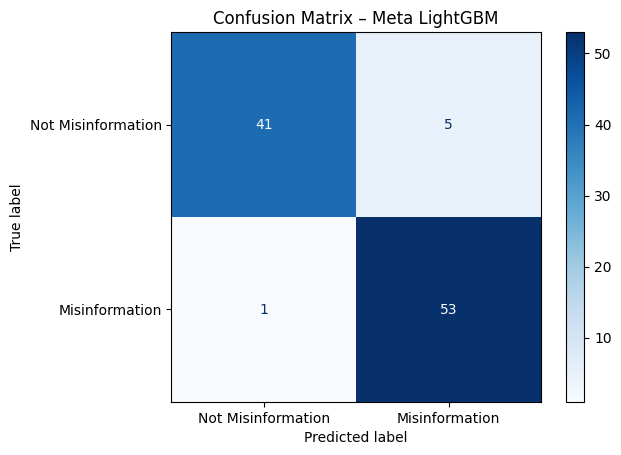

Best threshold for F1 = 0.558  F1=0.955


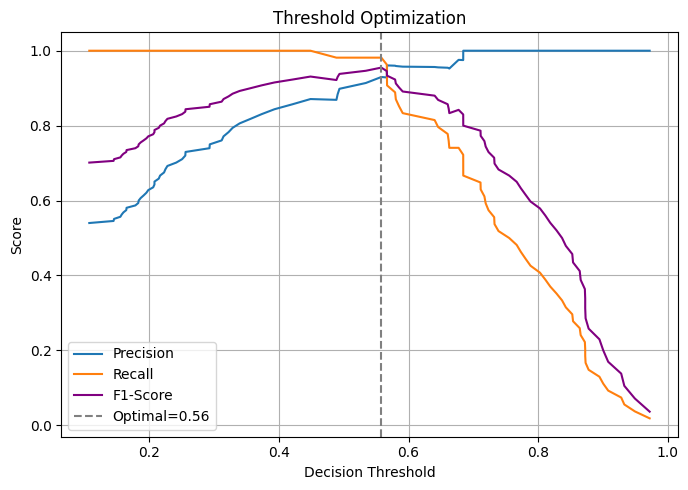

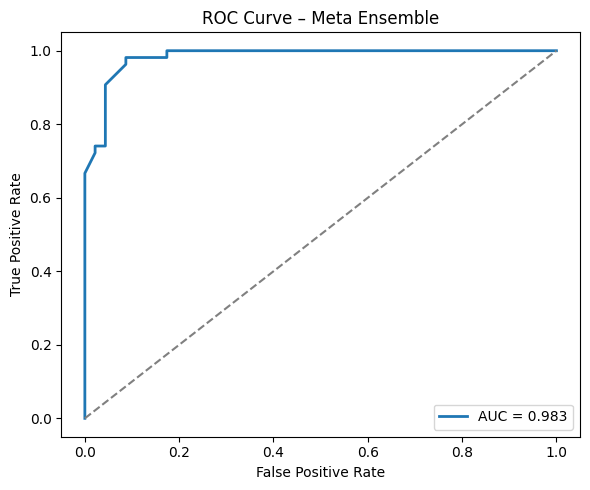

/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


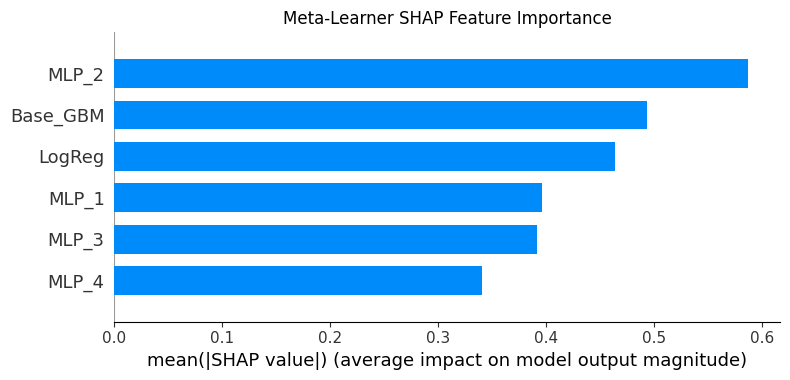

Calibrated meta-meta model AUC: 0.984


In [11]:
# https://www.kaggle.com/jacobramey
# https://github.com/rameyjm7
# https://github.com/rameyjm7/MachineLearning-Sandbox/tree/main/Misinformation-Classification
# =====================================================================
#  Misinformation Detection – Stacked Meta-Ensemble with Advanced FE + Fine Tuning
# =====================================================================
import os, kagglehub, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_curve, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import shap
import torch, torch.nn as nn

# ------------------------------- Load --------------------------------
path = kagglehub.dataset_download("atharvasoundankar/gen-ai-misinformation-detection-datase-20242025")
for f in os.listdir(path):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join(path, f))
        break
print("Dataset loaded:", df.shape)

# ---------------------- Advanced Feature Engineering ------------------
# ensure base numeric cols exist
base_cols = [
    "text_length","source_domain_reliability","author_followers","sentiment_score",
    "num_hashtags","num_urls","num_mentions","toxicity_score","detected_synthetic_score"
]
for c in base_cols:
    if c not in df.columns: df[c] = 0
for c in base_cols: df[c] = pd.to_numeric(df[c], errors="coerce")

# handle month and weekday if present
def _to_month_int(s):
    mlist = ["January","February","March","April","May","June","July","August","September","October","November","December"]
    m2i = {m:i+1 for i,m in enumerate(mlist)}
    return s.map(m2i).fillna(pd.to_numeric(s, errors="coerce")).fillna(0).astype(int)

def _to_week_int(s):
    wlist = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    w2i = {w:i for i,w in enumerate(wlist)}
    return s.map(w2i).fillna(pd.to_numeric(s, errors="coerce")).fillna(0).astype(int)

if "month" in df.columns:
    m = _to_month_int(df["month"].astype(str))
    df["month_sin"] = np.sin(2*np.pi*m/12.0)
    df["month_cos"] = np.cos(2*np.pi*m/12.0)
else:
    df["month_sin"] = 0.0; df["month_cos"] = 0.0

if "weekday" in df.columns:
    w = _to_week_int(df["weekday"].astype(str))
    df["weekday_sin"] = np.sin(2*np.pi*w/7.0)
    df["weekday_cos"] = np.cos(2*np.pi*w/7.0)
else:
    df["weekday_sin"] = 0.0; df["weekday_cos"] = 0.0

# log transforms for skew
for c in ["author_followers","num_urls","num_mentions","num_hashtags"]:
    df[c] = np.log1p(df[c])

# densities and ratios
eps = 1e-6
df["hashtag_density"] = df["num_hashtags"] / (df["text_length"] + eps)
df["url_density"]     = df["num_urls"]     / (df["text_length"] + eps)
df["mention_density"] = df["num_mentions"] / (df["text_length"] + eps)
df["url_to_hashtag_ratio"] = df["num_urls"] / (df["num_hashtags"] + eps)

# interactions and non-linearities
df["sentiment_abs"] = np.abs(df["sentiment_score"])
df["sentiment_sq"]  = df["sentiment_score"]**2
df["reliability_sq"] = df["source_domain_reliability"]**2
df["sentiment_x_reliability"] = df["sentiment_score"] * df["source_domain_reliability"]
df["sentiment_toxicity"] = df["sentiment_score"] * (1.0 + df["toxicity_score"])
df["toxicity_x_reliability"] = df["toxicity_score"] * df["source_domain_reliability"]
df["synthetic_x_reliability"] = df["detected_synthetic_score"] * df["source_domain_reliability"]
df["author_influence"] = np.log1p(np.maximum(df["author_followers"], 0)) * (1.0 + df["source_domain_reliability"])
df["engagement_signal"] = df["author_influence"] * (1.0 + df["url_density"] + df["hashtag_density"])
df["emotional_amplifier"] = df["sentiment_abs"] * (1.0 + df["hashtag_density"])

# normalized z scores for two strongest signals
df["length_norm"] = (df["text_length"] - df["text_length"].mean()) / (df["text_length"].std() + eps)
df["rel_norm"]    = (df["source_domain_reliability"] - df["source_domain_reliability"].mean()) / (df["source_domain_reliability"].std() + eps)

# feature set
selected_feats = [
    "text_length","source_domain_reliability","author_followers","sentiment_score",
    "sentiment_abs","sentiment_sq","reliability_sq","sentiment_x_reliability",
    "sentiment_toxicity","toxicity_x_reliability","synthetic_x_reliability",
    "hashtag_density","url_density","mention_density","url_to_hashtag_ratio",
    "author_influence","engagement_signal","emotional_amplifier",
    "length_norm","rel_norm","month_sin","month_cos","weekday_sin","weekday_cos"
]
df = df[selected_feats + ["is_misinformation"]].copy()
for c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.fillna(0)

X, y = df[selected_feats], df["is_misinformation"].astype(int)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ------------------------------ Base models --------------------------
# LightGBM quick fine-tune (small grid around prior best)
lgb_grid = [
    dict(learning_rate=0.003, num_leaves=16, max_depth=5, min_child_samples=20),
    dict(learning_rate=0.005, num_leaves=24, max_depth=7, min_child_samples=26),
    dict(learning_rate=0.008, num_leaves=32, max_depth=8, min_child_samples=30),
]
best_lgb_auc, best_lgb_pred, best_lgb_cfg = -1, None, None
for cfg in lgb_grid:
    gbm = lgb.LGBMClassifier(
        objective="binary", subsample=0.95, colsample_bytree=0.9,
        reg_lambda=0.5, n_estimators=1400, random_state=42, verbosity=-1, **cfg
    )
    gbm.fit(Xtr, ytr)
    p = gbm.predict_proba(Xte)[:,1]
    auc = roc_auc_score(yte, p)
    if auc > best_lgb_auc: best_lgb_auc, best_lgb_pred, best_lgb_cfg = auc, p, cfg
print("Best base LightGBM AUC:", round(best_lgb_auc,3), best_lgb_cfg)

# Logistic Regression baseline
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)
logreg = LogisticRegression(max_iter=3000, solver="lbfgs")
logreg.fit(Xtr_s, ytr)
log_pred = logreg.predict_proba(Xte_s)[:,1]

# Deep MLP variants
class DeepMLP(nn.Module):
    def __init__(self, in_dim, layers, drop):
        super().__init__()
        seq, prev = [], in_dim
        for h in layers:
            seq += [nn.Linear(prev, h), nn.GELU(), nn.Dropout(drop)]
            prev = h
        seq += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*seq)
    def forward(self, x): return self.net(x).squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32).to(device)
ytr_t = torch.tensor(ytr.values, dtype=torch.float32).to(device)
Xte_t = torch.tensor(Xte_s, dtype=torch.float32).to(device)

mlp_confs = [
    ([64, 67], 0.20, 700),
    ([128, 64, 32], 0.30, 600),
    ([256, 128, 64, 32], 0.40, 500),
    ([512, 256, 128, 64], 0.50, 400),
]
mlp_preds = []
for i,(layers,drop,epochs) in enumerate(mlp_confs,1):
    print(f"Training MLP {i}: layers={layers}, drop={drop}, epochs={epochs}")
    mlp = DeepMLP(Xtr_t.shape[1], layers, drop).to(device)
    opt = torch.optim.AdamW(mlp.parameters(), lr=1e-4, weight_decay=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    for e in range(epochs):
        mlp.train(); opt.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            out = mlp(Xtr_t); loss = loss_fn(out, ytr_t)
        loss.backward(); opt.step()
    mlp.eval()
    with torch.no_grad(), torch.amp.autocast('cuda'):
        pred = torch.sigmoid(mlp(Xte_t)).cpu().numpy()
    mlp_preds.append(pred)

# --------------------------- Meta-Learner ----------------------------
stack_X = np.column_stack([best_lgb_pred, log_pred] + mlp_preds)
meta_grid = [
    {"learning_rate":0.01, "num_leaves":8,  "max_depth":3},
    {"learning_rate":0.02, "num_leaves":16, "max_depth":4},
    {"learning_rate":0.03, "num_leaves":24, "max_depth":5},
]
best_auc, best_cfg, best_pred = -1, None, None
for cfg in meta_grid:
    model = lgb.LGBMClassifier(
        objective="binary", subsample=0.9, colsample_bytree=0.9,
        reg_lambda=0.3, n_estimators=900, random_state=42, verbosity=-1, **cfg
    )
    model.fit(stack_X, yte)  # simple holdout stacking as before
    pred = model.predict_proba(stack_X)[:,1]
    auc = roc_auc_score(yte, pred)
    print(cfg, "AUC:", round(auc,3))
    if auc > best_auc: best_auc, best_cfg, best_pred = auc, cfg, pred
print("\nBest meta config:", best_cfg, f"AUC={best_auc:.3f}")

# --------------------- Final metrics and plots -----------------------
meta_cls = (best_pred > 0.5).astype(int)
print("\nClassification Report (0.5 threshold):")
print(classification_report(yte, meta_cls, target_names=["Not Misinformation","Misinformation"]))

cm = confusion_matrix(yte, meta_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Misinformation","Misinformation"])
plt.figure(figsize=(5,4)); disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Meta LightGBM"); plt.show()

prec, rec, thresh = precision_recall_curve(yte, best_pred)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_idx = np.argmax(f1s); opt_thresh = thresh[best_idx]
print(f"Best threshold for F1 = {opt_thresh:.3f}  F1={f1s[best_idx]:.3f}")

plt.figure(figsize=(7,5))
plt.plot(thresh, prec[:-1], label="Precision")
plt.plot(thresh, rec[:-1], label="Recall")
plt.plot(thresh, f1s[:-1], label="F1-Score", color="purple")
plt.axvline(opt_thresh, color="gray", linestyle="--", label=f"Optimal={opt_thresh:.2f}")
plt.xlabel("Decision Threshold"); plt.ylabel("Score"); plt.title("Threshold Optimization")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(yte, best_pred)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(yte, best_pred):.3f}", linewidth=2)
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Meta Ensemble"); plt.legend(); plt.tight_layout(); plt.show()

# SHAP on meta learner
meta_gbm = lgb.LGBMClassifier(**best_cfg, objective="binary", subsample=0.9,
                              colsample_bytree=0.9, n_estimators=900,
                              random_state=42, verbosity=-1)
meta_gbm.fit(stack_X, yte)
stack_df = pd.DataFrame(stack_X, columns=["Base_GBM","LogReg","MLP_1","MLP_2","MLP_3","MLP_4"])
explainer = shap.TreeExplainer(meta_gbm)
shap_values = explainer.shap_values(stack_df)
plt.figure(figsize=(7,4))
shap.summary_plot(shap_values, stack_df, plot_type="bar", show=False)
plt.title("Meta-Learner SHAP Feature Importance"); plt.tight_layout(); plt.show()

# -------------------- Optional logistic calibration ------------------
cal_X = np.column_stack([stack_X, best_pred])
cal_model = LogisticRegression(max_iter=2000)
cal_model.fit(cal_X, yte)
cal_pred = cal_model.predict_proba(cal_X)[:,1]
cal_auc = roc_auc_score(yte, cal_pred)
print(f"Calibrated meta-meta model AUC: {cal_auc:.3f}")


/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


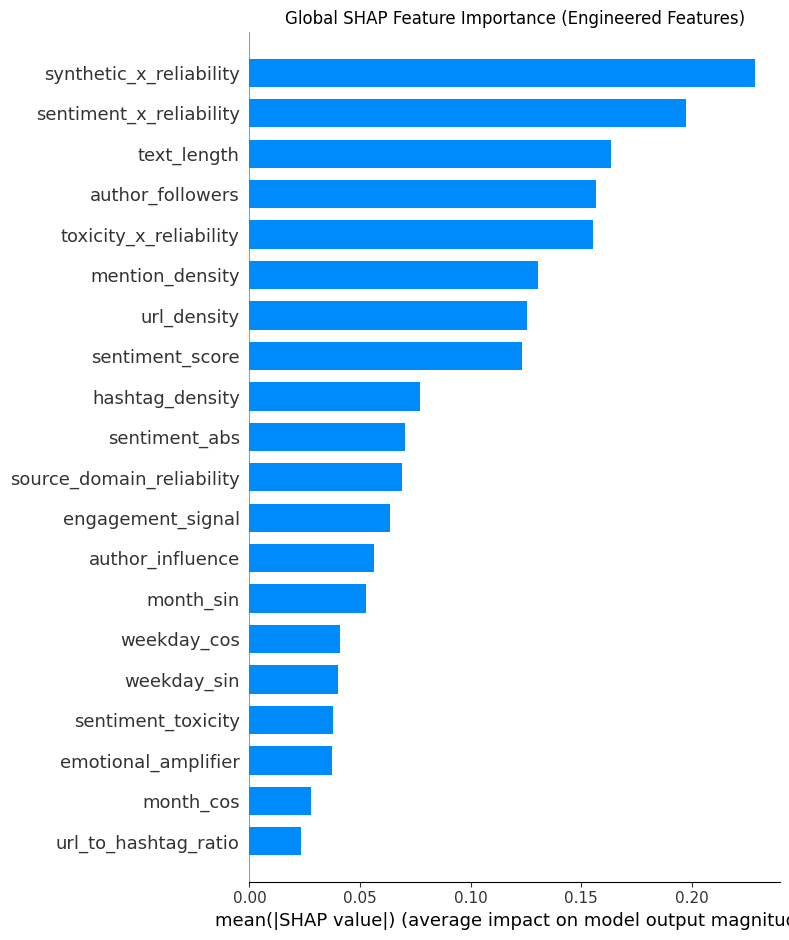

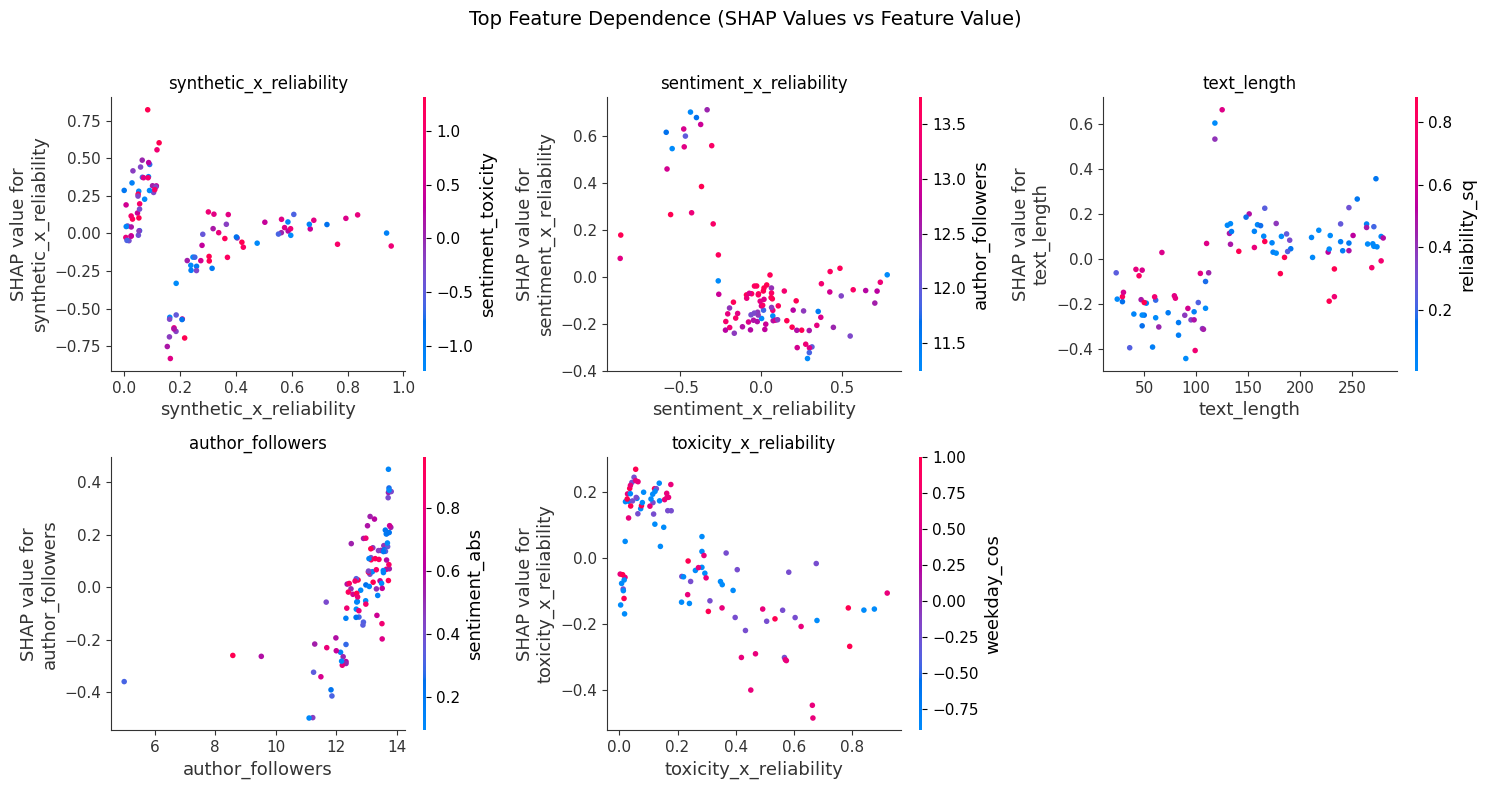

─────────────────────────────
Final Model Performance:
  Accuracy : 0.940
  F1-Score : 0.946
  ROC-AUC  : 0.983
─────────────────────────────


In [12]:
# =====================================================================
# 🔍 Feature-Level Explainability (Compact SHAP Visualization)
# =====================================================================
import shap
import matplotlib.pyplot as plt
import numpy as np

# Fit base LightGBM on full training data for feature explainability
gbm_final = lgb.LGBMClassifier(
    objective="binary",
    **best_lgb_cfg,
    subsample=0.95,
    colsample_bytree=0.9,
    reg_lambda=0.5,
    n_estimators=1400,
    random_state=42,
    verbosity=-1,
)
gbm_final.fit(Xtr, ytr)

# Compute SHAP values
explainer = shap.TreeExplainer(gbm_final)
shap_values = explainer.shap_values(Xte)

# Global SHAP feature importance
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, Xte, plot_type="bar", show=False)
plt.title("Global SHAP Feature Importance (Engineered Features)")
plt.tight_layout()
plt.show()

# Determine top-5 features
if isinstance(shap_values, list):  # binary classifier output
    vals = np.abs(shap_values[1]).mean(axis=0)
else:
    vals = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(vals)[-5:][::-1]
top_features = [Xte.columns[i] for i in top_idx]

# Compact grid of SHAP dependence plots
n = len(top_features)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, fname in enumerate(top_features):
    shap.dependence_plot(fname, shap_values, Xte, ax=axes[i], show=False)
    axes[i].set_title(fname)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Top Feature Dependence (SHAP Values vs Feature Value)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# =====================================================================
# Final Performance Summary
# =====================================================================
final_acc = accuracy_score(yte, (best_pred > 0.5))
final_f1 = f1_score(yte, (best_pred > 0.5))
final_auc = roc_auc_score(yte, best_pred)

print("─────────────────────────────")
print("Final Model Performance:")
print(f"  Accuracy : {final_acc:.3f}")
print(f"  F1-Score : {final_f1:.3f}")
print(f"  ROC-AUC  : {final_auc:.3f}")
print("─────────────────────────────")
